# This code takes in date ranges from the user, then uses them to set the "before" vs. "after" dates' colors.

### This cell has the user inptu the path to the .npz file and the .json recording dates/treatment dates file (we need this to set the recording dates to the correct year later)

In [1]:
import re
import numpy as np
import json

# Paths to the .npz and .json files
path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Desktop/RC7_USA5499_tweetybert_outputs/USA5499.npz'

#The user still needs to give them the path to the .json file, so it can set the correct the year(s) of the recording
path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Desktop/RC7_USA5499_tweetybert_outputs/RC7_USA5499_Comp2_treatment_and_recording_dates.json'
# Use a regular expression to find the pattern 'USA' followed by 4 digits for the animal ID
match = re.search(r"(USA\d{4})", path_to_json_file_with_dates)
if match:
    animal_id = match.group(1)
    print(f"Animal ID: {animal_id}")
else:
    print("Animal ID not found in the file path.")

# Load the JSON file and extract the treatment date
with open(path_to_json_file_with_dates, 'r') as file:
    json_data = json.load(file)
# Extract and print the treatment date
treatment_date = json_data.get("treatment_date", "Treatment date not found")
treatment_type = json_data.get("treatment_type", "Treatment type not found")
print(f"Treatment Date: {treatment_date}")
print(f"Treatment Type: {treatment_type}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Animal ID: USA5499
Treatment Date: 2025-02-20
Treatment Type: Bilateral Area X excitotoxic lesions


### Make a function to find the year from the file, then set the dates for each UMAP coordinate in the .npz file

In [2]:
import numpy as np
import json

# # Paths to the files
# path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508.npz'
# path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508_creation_data.json'

# Load the .npz file
data = np.load(path_to_npz_file_from_TweetyBERT, allow_pickle=True)

# Extract the dictionary
file_map_dictionary = data['file_map'].item()

# Load the creation_data.json
with open(path_to_json_file_with_dates, 'r') as json_file:
    creation_data = json.load(json_file)

# Extract the year from 'treatment_date'
treatment_date = creation_data.get('treatment_date')
if treatment_date is None:
    raise ValueError("Treatment date not found in creation_data.")

# Parse the year from the 'treatment_date'
year = treatment_date.split('-')[0]

# Iterate over each key in the file_map_dictionary
for key in file_map_dictionary.keys():
    # Get the filename tuple
    filename_tuple = file_map_dictionary[key]
    
    # Extract the filename string
    sample_file_name = filename_tuple[0]
    
    # Split the string by underscores
    parts = sample_file_name.split('_')
    
    # Extract date and time components
    try:
        month = parts[2]  # '10' - October
        day = parts[3]    # '8'
        hour = parts[4]   # '12'
        minute = parts[5] # '33'
    except IndexError:
        print(f"Error: Filename parts do not have enough components for key {key}. Skipping.")
        continue  # Skip to the next key
    
    # Ensure all components are two digits
    month = month.zfill(2)
    day = day.zfill(2)
    hour = hour.zfill(2)
    minute = minute.zfill(2)
    
    # Validate numeric ranges
    try:
        hour_int = int(hour)
        minute_int = int(minute)
        if not (0 <= hour_int < 24):
            print(f"Invalid hour value: {hour_int} for key {key}. Skipping.")
            continue  # Skip to the next key
        if not (0 <= minute_int < 60):
            print(f"Invalid minute value: {minute_int} for key {key}. Skipping.")
            continue  # Skip to the next key
    except ValueError:
        print(f"Invalid numeric value in date components for key {key}. Skipping.")
        continue  # Skip to the next key
    
    # Create datetime string
    datetime_str = f"{year}-{month}-{day}T{hour}:{minute}"
    
    # Convert to NumPy datetime64
    datetime_np = np.datetime64(datetime_str)
    
    # Update the tuple to include datetime_np
    new_tuple = filename_tuple + (datetime_np,)
    
    # Update the dictionary
    file_map_dictionary[key] = new_tuple

# Now, file_map_dictionary has updated tuples with datetime included

# Optional: To verify the updates, you can print the updated file_map_dictionary
#for key, value in file_map_dictionary.items():
#    print(f"Key: {key}, Value: {value}")

# Corrected variable name 
#print(file_map_dictionary)

####################################################################################################################################################################################
import numpy as np
import pandas as pd

# Assuming 'data' and 'file_map_dictionary' are already loaded as per your previous code.

# Convert file_map_dictionary to a DataFrame
file_map_df = pd.DataFrame.from_dict(file_map_dictionary, orient='index')

# Reset the index to ensure it aligns with sample_file_indices
file_map_df.reset_index(inplace=True)
file_map_df.rename(columns={'index': 'file_index'}, inplace=True)

# Extract the necessary columns
# Assuming the datetime is in the second position (column 1)
file_map_df = file_map_df[[0, 1]]
file_map_df.columns = ['Filename', 'DateTime']

# Extract the sample file indices as a numpy array
sample_file_indices = data['file_indices']

# Create a DataFrame for the sample file indices
sample_df = pd.DataFrame({'file_index': sample_file_indices})

# Merge the sample_df with file_map_df on 'file_index' to get the DateTime
merged_df = sample_df.merge(file_map_df, left_on='file_index', right_index=True, how='left')

# Extract the dates (convert numpy.datetime64 to date)
merged_df['Date'] = merged_df['DateTime'].values.astype('datetime64[D]')

# Assign the UMAP coordinates directly
merged_df['Coordinate'] = list(data['embedding_outputs'])

# Select only the necessary columns
final_df = merged_df[['Date', 'Coordinate']]

# Reset index if needed
final_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print("First 10 rows of the final_df, which contains the dates of the recording and the corresponding coordinate:")
print(final_df.head(10))

# Extracting unique dates from the final DataFrame
unique_dates = final_df['Date'].unique()

# Sorting the dates
sorted_dates = np.sort(unique_dates)

# Printing each unique date in order
print("Unique dates in the dataset (sorted from earliest to latest):")
for date in sorted_dates:
    print(date)
print(date)

First 10 rows of the final_df, which contains the dates of the recording and the corresponding coordinate:
        Date               Coordinate
0 2025-02-13    [1.4382645, 8.085046]
1 2025-02-13     [1.422664, 8.072954]
2 2025-02-13     [1.419539, 8.074727]
3 2025-02-13    [1.4050723, 8.062076]
4 2025-02-13  [-2.7860272, 6.3809247]
5 2025-02-13   [-2.191499, 6.8302293]
6 2025-02-13  [-2.0557852, 7.6873765]
7 2025-02-13   [-2.4055848, 8.149535]
8 2025-02-13    [-3.428142, 8.214949]
9 2025-02-13    [-4.125994, 7.967853]
Unique dates in the dataset (sorted from earliest to latest):
2025-02-07T00:00:00
2025-02-08T00:00:00
2025-02-09T00:00:00
2025-02-10T00:00:00
2025-02-11T00:00:00
2025-02-12T00:00:00
2025-02-13T00:00:00
2025-02-15T00:00:00
2025-02-16T00:00:00
2025-02-17T00:00:00
2025-02-18T00:00:00
2025-02-19T00:00:00
2025-02-24T00:00:00
2025-02-25T00:00:00
2025-02-26T00:00:00
2025-02-27T00:00:00
2025-02-28T00:00:00
2025-03-01T00:00:00
2025-03-03T00:00:00
2025-03-04T00:00:00
2025-03-05T00

/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_26674/2777823676.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Date'] = pd.to_datetime(final_df['Date'])
/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_26674/2777823676.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[['X', 'Y']] = coordinates
/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_26674/2777823676.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

Number of data points in the 'before' range: 89020
Number of data points in the 'after' range: 198722


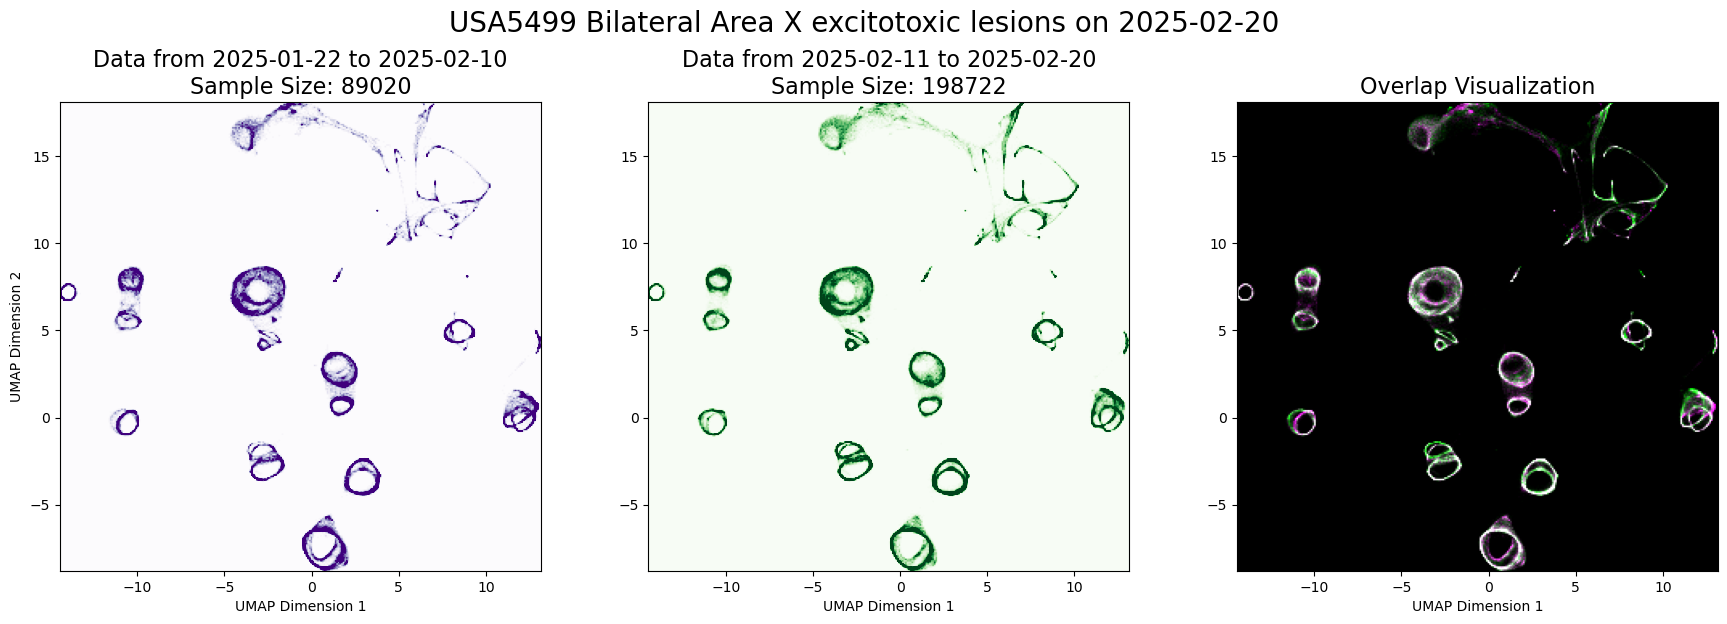

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# User-defined date ranges
date_range_before = ['2025-01-22', '2025-02-20']  # Define start and end date for the "before" dataset
date_range_after = ['2025-02-21', '2025-03-07']  # Define start and end date for the "after" dataset

# Assuming 'final_df' is your DataFrame with 'Date' and 'Coordinate' columns
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Split 'Coordinate' column into 'X' and 'Y'
coordinates = pd.DataFrame(final_df['Coordinate'].tolist(), columns=['X', 'Y'])
final_df[['X', 'Y']] = coordinates

# Filter coordinates based on user-defined date ranges
before_treatment = final_df[(final_df['Date'] >= pd.to_datetime(date_range_before[0])) & (final_df['Date'] <= pd.to_datetime(date_range_before[1]))]
after_treatment = final_df[(final_df['Date'] >= pd.to_datetime(date_range_after[0])) & (final_df['Date'] <= pd.to_datetime(date_range_after[1]))]

# Print the number of datapoints for each dataset
num_before = len(before_treatment)
num_after = len(after_treatment)
print(f"Number of data points in the 'before' range: {num_before}")
print(f"Number of data points in the 'after' range: {num_after}")

# Define bins for the heatmap
bins = 300

# Create a 2D histogram for data before treatment
heatmap_before, xedges, yedges = np.histogram2d(before_treatment['X'], before_treatment['Y'], bins=bins)

# Create a 2D histogram for data after treatment
heatmap_after, _, _ = np.histogram2d(after_treatment['X'], after_treatment['Y'], bins=[xedges, yedges])

# Normalize each heatmap independently
heatmap_before = heatmap_before / heatmap_before.max()
heatmap_after = heatmap_after / heatmap_after.max()

# Create an RGB image with purple and green channels for overlap visualization
rgb_image = np.zeros((heatmap_before.shape[0], heatmap_before.shape[1], 3))
brightness_factor = 6  # Adjust this value as needed to make the colors brighter
rgb_image[..., 0] = np.clip(heatmap_before.T * brightness_factor, 0, 1)  # Red channel for purple
rgb_image[..., 1] = np.clip(heatmap_after.T * brightness_factor, 0, 1)   # Green channel for green
rgb_image[..., 2] = np.clip(heatmap_before.T * brightness_factor, 0, 1)  # Blue channel for purple

# Plot the two heatmaps separately and the combined RGB plot
plt.figure(figsize=(18, 6))

# Plot for data before the defined date range
plt.subplot(1, 3, 1)
plt.imshow(heatmap_before.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Purples', vmax=0.1)
plt.title(f"Data from {date_range_before[0]} to {date_range_before[1]}\nSample Size: {num_before}", fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Plot for data after the defined date range
plt.subplot(1, 3, 2)
plt.imshow(heatmap_after.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Greens', vmax=0.1)
plt.title(f"Data from {date_range_after[0]} to {date_range_after[1]}\nSample Size: {num_after}", fontsize=16)
plt.xlabel('UMAP Dimension 1')

# Plot combined RGB image
plt.subplot(1, 3, 3)
plt.imshow(rgb_image, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower')
plt.title("Overlap Visualization", fontsize=16)
plt.xlabel('UMAP Dimension 1')

# Main title and layout
plt.suptitle(f"{animal_id} {treatment_type} on {treatment_date}", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()
